<a href="https://colab.research.google.com/github/Aleksypruszkowski/Machine-Learning-MIMUW/blob/main/Lab09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9 - Multi Layer Perceptron, MLP

### Author: Aleksy Pruszkowski

As we did in class we load the MNIST dataset and train a NN.

In [1]:
import torch
import torchvision
from matplotlib import pyplot

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.89MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.11MB/s]


In [2]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(1*28*28, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)

net.train()
for epoch in range(8):

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean")
        loss.backward()
        optimizer.step()



---
## Task 1

Let's start with generating gaussian noise

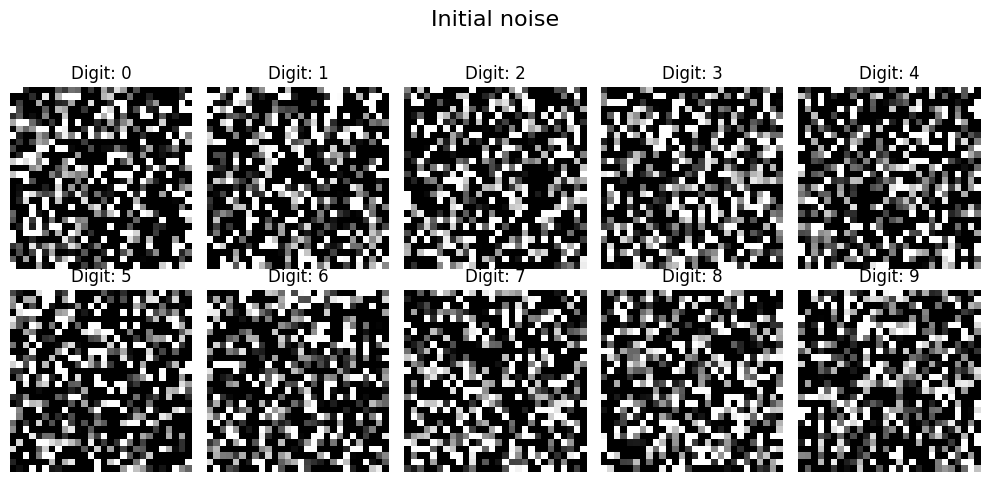

In [30]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dream_images = torch.randn(10, 1, 28, 28, requires_grad=True, device=device)
with torch.no_grad():
    dream_images.clamp_(0, 1)
target_labels = torch.arange(10, device=device)
images = dream_images.detach().cpu().numpy()
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Initial noise", fontsize=16)

for i, ax in enumerate(axs.flat):
    img = images[i, 0, :, :]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Digit: {target_labels[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


Let's now optimize the images. We proceed similarly as before. At each step we have to additionally ensure that value for each pixel stays between 0 and 1.

In [31]:
trainloader = torch.utils.data.DataLoader(dream_images,
                                          batch_size=10,
                                          shuffle=False)
net2 = MLP().to(device)
net.eval()
optimizer = torch.optim.Adam([dream_images], lr=0.01)

confidence_history = []
net2.train()
n_epochs = 10000
for epoch in range(n_epochs):
    for batch, data in enumerate(trainloader):
        inputs = data
        labels = target_labels
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        batch_outputs = net(inputs)
        loss = torch.nn.functional.cross_entropy(batch_outputs, labels, reduction = "mean")
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            dream_images.clamp_(0, 1)
        probs = torch.softmax(batch_outputs, dim=1)
        confidences = probs[range(10), target_labels].detach().cpu()
        confidence_history.append(confidences.numpy())
    if confidences.mean() >=1:
        print(f"Step {epoch}, Loss: {loss.item():.4f}, Mean Confidence: {confidences.mean():.4f}")
        break

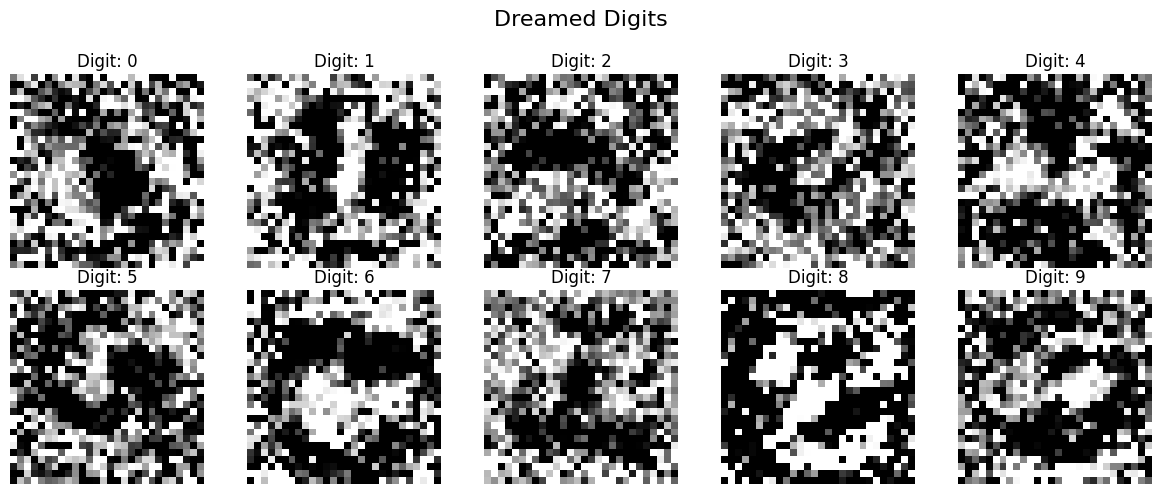

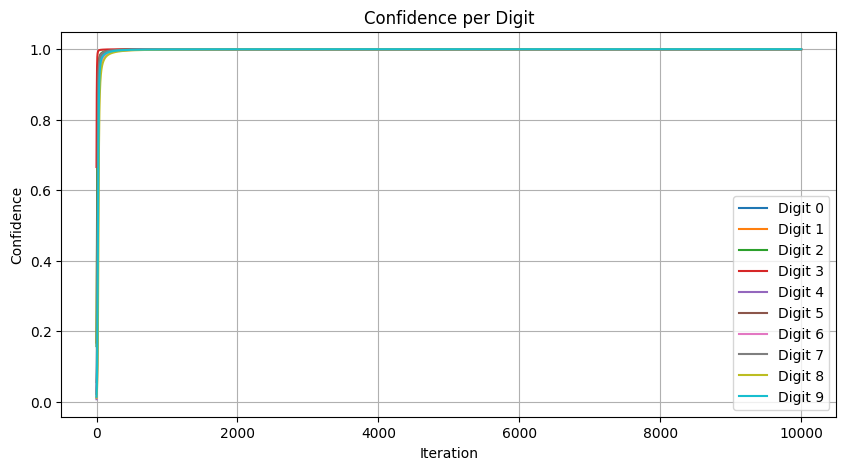

In [32]:
import matplotlib.pyplot as plt
images = dream_images.detach().cpu().numpy()
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Dreamed Digits", fontsize=16)

for i, ax in enumerate(axs.flat):
    img = images[i, 0, :, :]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Digit: {target_labels[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

confidence_history = np.stack(confidence_history)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.plot(confidence_history[:, i], label=f'Digit {i}')
plt.xlabel('Iteration')
plt.ylabel('Confidence')
plt.title('Confidence per Digit')
plt.legend()
plt.grid(True)
plt.show()

Despite noisy background most digits can be recognised, "6" and "7" are less clear than the rest.



---
## Task 2



### Ideas:
1. For two neighbouring labels (eg. 1 and 2) we could put a target label 1.5
2. Training initial neural network on a dataset for which two chosen classes are merged (seems extremely time consuming)
3. Aiming to minimise sum of losses for two chosen classes (we will try this below)

In [41]:
hybrid_targets1 = torch.tensor([0,1,2,3,4,5,6,7,8,9])
hybrid_targets2 = torch.tensor([2,7,4,8,6,7,8,9,0,6])
dream_images = torch.randn(10, 1, 28, 28, requires_grad=True, device=device)

net2 = MLP().to(device)
net.eval()
optimizer = torch.optim.Adam([dream_images], lr=0.01)

confidence_history = []
net2.train()
n_epochs = 10000
for epoch in range(n_epochs):
    for batch, data in enumerate(trainloader):
        inputs = data
        labels1 = hybrid_targets1.to(device)
        labels2 = hybrid_targets2.to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        batch_outputs = net(inputs)
        loss = torch.nn.functional.cross_entropy(batch_outputs, labels1, reduction = "mean")+torch.nn.functional.cross_entropy(batch_outputs, labels2, reduction = "mean")
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            dream_images.clamp_(0, 1)
    if epoch == n_epochs-1:
          probs = torch.softmax(batch_outputs, dim=1)
          confidences = probs[range(10), target_labels].detach().cpu()
          confidence_history.append(confidences.numpy())
          print(f"Step {epoch}, Loss: {loss.item():.4f}, Mean Confidence: {confidences.mean():.4f}")

Step 9999, Loss: 17.1918, Mean Confidence: 1.0000


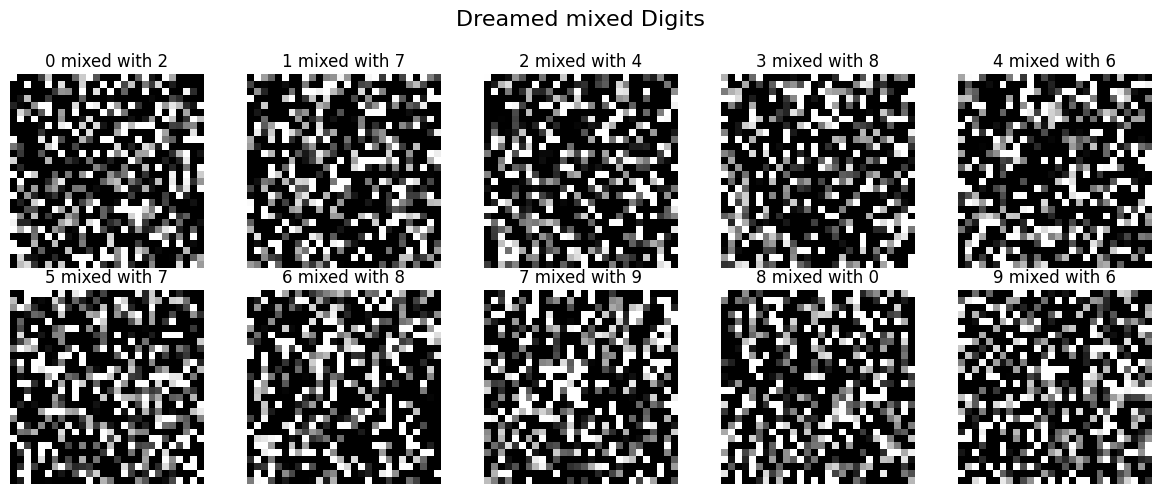

In [42]:
import matplotlib.pyplot as plt
images = dream_images.detach().cpu().numpy()
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Dreamed mixed Digits", fontsize=16)

for i, ax in enumerate(axs.flat):
    img = images[i, 0, :, :]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{hybrid_targets1[i].item()} mixed with {hybrid_targets2[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

The images are unclear to me. Let's try the second idea.

In [45]:
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_merged = MLP().to(device)
optimizer = torch.optim.Adam(net_merged.parameters(), 0.001)

net.train()
for epoch in range(8):

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        batch_labels[batch_labels == 8] = 3

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean")
        loss.backward()
        optimizer.step()

In [47]:
hybrid_targets1 = torch.tensor([0,1,2,3,4,5,6,7,2,9])
hybrid_targets2 = torch.tensor([2,7,4,3,6,7,5,9,0,6])
trainloader = torch.utils.data.DataLoader(dream_images,
                                          batch_size=10,
                                          shuffle=False)
dream_images = torch.randn(10, 1, 28, 28, requires_grad=True, device=device)

net2 = MLP().to(device)
net_merged.eval()
optimizer = torch.optim.Adam([dream_images], lr=0.01)

confidence_history = []
net2.train()
n_epochs = 10000
for epoch in range(n_epochs):
    for batch, data in enumerate(trainloader):
        inputs = data
        labels1 = hybrid_targets1.to(device)
        labels2 = hybrid_targets2.to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        batch_outputs = net_merged(inputs)
        loss = torch.nn.functional.cross_entropy(batch_outputs, labels1, reduction = "mean")+torch.nn.functional.cross_entropy(batch_outputs, labels2, reduction = "mean")
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            dream_images.clamp_(0, 1)
    if epoch == n_epochs-1:
          probs = torch.softmax(batch_outputs, dim=1)
          confidences = probs[range(10), target_labels].detach().cpu()
          confidence_history.append(confidences.numpy())
          print(f"Step {epoch}, Loss: {loss.item():.4f}, Mean Confidence: {confidences.mean():.4f}")

Step 9999, Loss: 4.6256, Mean Confidence: 0.1007


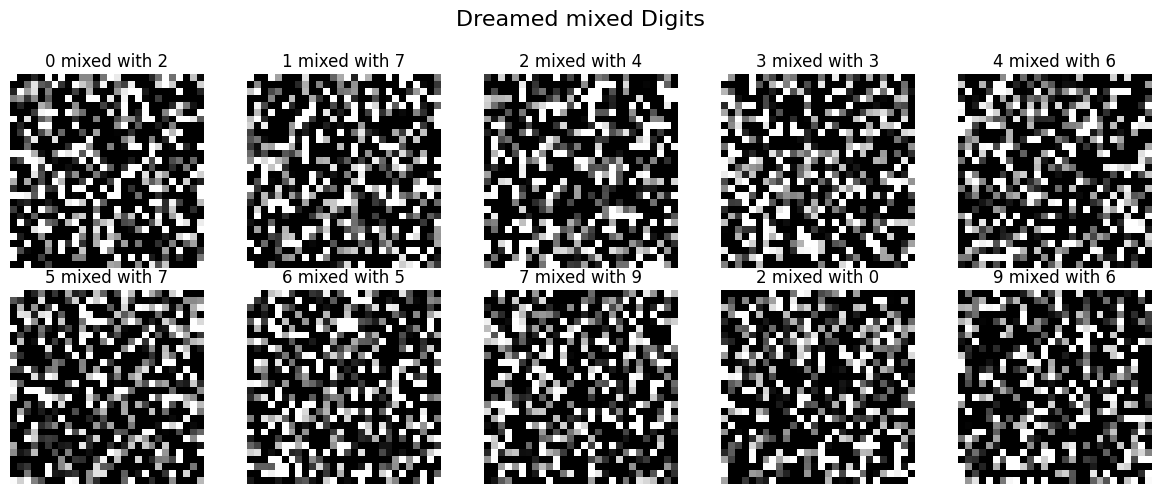

In [48]:
images = dream_images.detach().cpu().numpy()
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Dreamed mixed Digits", fontsize=16)

for i, ax in enumerate(axs.flat):
    img = images[i, 0, :, :]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{hybrid_targets1[i].item()} mixed with {hybrid_targets2[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

3 mixed with 3 is the generated image for classes 3 and 8 merged in the original dataset, but they look similar to the ones generated using the third idea.



---
## Task 3

Training with lambda_l2 = 0.001
Step 9999, Loss: 0.0002, Mean Confidence: 1.0000


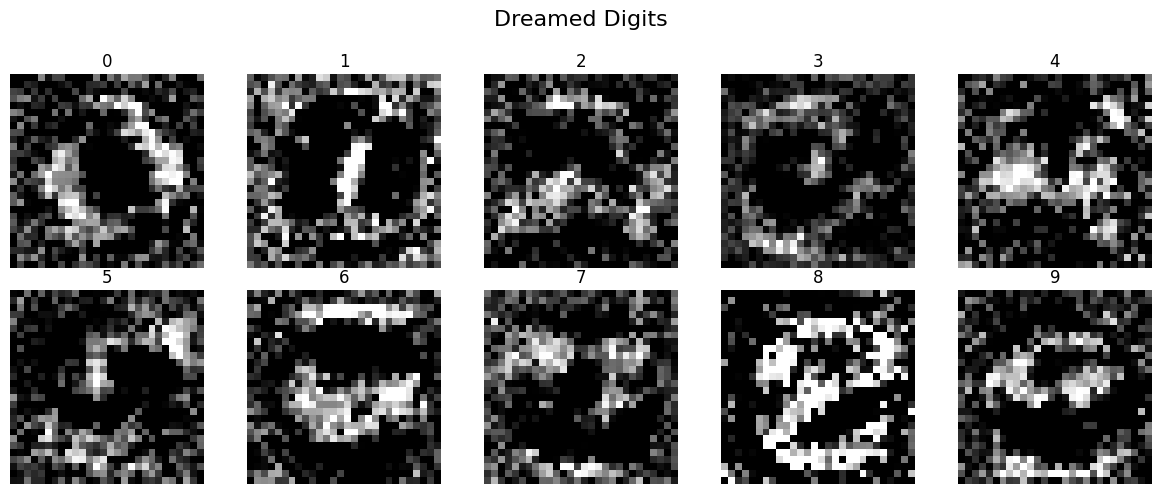

Training with lambda_l2 = 0.01
Step 9999, Loss: 0.0010, Mean Confidence: 0.9998


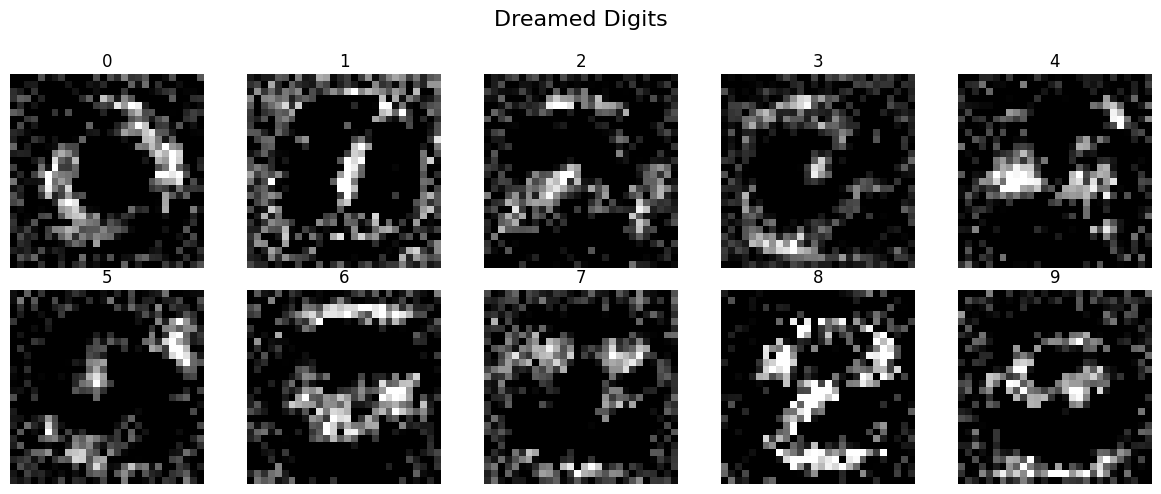

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dream_images = torch.randn(10, 1, 28, 28, requires_grad=True, device=device)
dream_original = dream_images
target_labels = torch.arange(10, device=device)

net2 = MLP().to(device)
net.eval()
net2.train()
n_epochs = 10000
lambdas = [0.001, 0.01, 0.1, 1.0, 10.0]
for lambda_l2 in lambdas:
    print(f"Training with lambda_l2 = {lambda_l2}")
    dream_images = dream_original
    trainloader = torch.utils.data.DataLoader(dream_images,
                                          batch_size=10,
                                          shuffle=False)
    optimizer = torch.optim.Adam([dream_images], lr=0.01)
    for epoch in range(n_epochs):
        for batch, data in enumerate(trainloader):
            inputs = data
            labels = target_labels
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            batch_outputs = net(inputs)
            loss = torch.nn.functional.cross_entropy(batch_outputs, labels, reduction = "mean") + lambda_l2 * dream_images.pow(2).mean()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                dream_images.clamp_(0, 1)
        if epoch == n_epochs-1:
            probs = torch.softmax(batch_outputs, dim=1)
            confidences = probs[range(10), target_labels].detach().cpu()
            print(f"Step {epoch}, Loss: {loss.item():.4f}, Mean Confidence: {confidences.mean():.4f}")
    images = dream_images.detach().cpu().numpy()
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle("Dreamed Digits", fontsize=16)

    for i, ax in enumerate(axs.flat):
        img = images[i, 0, :, :]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{target_labels[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()


Final images for small lambda_l2 are as expected similar to results for task 1. As lambda_l2 gets larger, the images get darker but the background becomes less noisy. The digits sand out more.